In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [18]:
# --- 1. Data Generation and Price Forecasting ---

def generate_energy_data(days=1, forecast_volatility_factor=1.0):
    """Generates synthetic hourly data for a 24-hour period, including a price forecast."""
    
    # 1. Historical Data (Simple Linear Relationship)
    X_hist = np.array([5, 15, 25, 35, 45, 55]).reshape((-1, 1))
    y_hist = np.array([50, 75, 60, 90, 80, 110]) * forecast_volatility_factor # Historical Price (€/MWh)

    # Train Linear Regression Model
    model = LinearRegression()
    model.fit(X_hist, y_hist)

    # 2. 24-Hour Price Forecast
    X_forecast = np.arange(60, 60 + days * 24 * 10, 10).reshape((-1, 1)) 
    prices = model.predict(X_forecast)

    # Simulate realistic price fluctuations (Price Volatility)
    noise = np.random.normal(0, 5 * forecast_volatility_factor, prices.shape)
    prices += noise
    
    # Ensure no negative prices
    prices[prices < 0] = 5 
    
    # Generate Synthetic Frequency Data (for Balancing Market)
    frequency_data = np.full(len(prices), 50.00)
    # Simulate low frequency events for aFRR/FCR revenue
    frequency_data[np.random.randint(0, len(prices), int(len(prices)*0.1))] = 49.975 
    frequency_data[np.random.randint(0, len(prices), int(len(prices)*0.1))] = 50.030 
    
    return prices, frequency_data, model


In [19]:
# --- 2. BESS Operational Logic (Revenue Stacking) ---

def bess_operational_model(prices, frequencies, capacity_mwh, initial_soc, eff, max_c_rate):
    """
    Combines price arbitrage and balancing market (FCR/aFRR) decisions 
    to maximize short-term profit.
    """
    
    capacity = capacity_mwh 
    charge_level = initial_soc * capacity
    
    # Parameters for Arbitrage 
    avg_price = prices.mean()
    max_arb_power = max_c_rate * capacity 
    
    # Parameters for Balancing Market
    REF_FREQ = 50.00
    FCR_THRESHOLD = 0.02
    
    total_profit = 0
    decisions = []
    charge_levels_over_time = [charge_level]
    
    reserve_contract_payment_per_hour = 50 
    
    for i, price in enumerate(prices):
        freq = frequencies[i]
        
        # --- A. Balancing Market (Highest Priority) ---
        power_from_reserve = 0 
        
        # Check for FCR/aFRR need (Frequency Deviation)
        freq_dev = freq - REF_FREQ
        if abs(freq_dev) > FCR_THRESHOLD:
            # FCR/aFRR Power needed is proportional to deviation
            # Positive power = Discharge; Negative power = Charge
            power_needed = -freq_dev * 1000 
            power_from_reserve = max(min(power_needed, max_arb_power), -max_arb_power)
            
            # Balancing Market Revenue: Payment for capacity plus service delivery
            reserve_revenue = abs(power_from_reserve) * 200 * 1 
            total_profit += reserve_revenue
            decisions.append('FCR/aFRR')
        
        # --- B. Price Arbitrage (Secondary Priority) ---
        else:
            if price < avg_price * 0.9 and charge_level < capacity:
                # Charge (Buy Low)
                power_arb = min(capacity - charge_level, max_arb_power)
                total_profit -= power_arb * price  # Cost
                charge_level += power_arb * eff
                decisions.append('Charge (Arb)')
                
            elif price > avg_price * 1.1 and charge_level > 0:
                # Discharge (Sell High)
                power_arb = min(charge_level, max_arb_power)
                total_profit += power_arb * eff * price  # Revenue
                charge_level -= power_arb
                decisions.append('Discharge (Arb)')
                
            else:
                decisions.append('Hold')
        
        # Apply energy change from Balancing Market (if active)
        if power_from_reserve > 0: # Discharge
            energy_change = min(charge_level, power_from_reserve)
            total_profit += energy_change * eff * price 
            charge_level -= energy_change
            
        elif power_from_reserve < 0: # Charge
            energy_change = min(capacity - charge_level, -power_from_reserve)
            total_profit -= energy_change * price 
            charge_level += energy_change * eff
            
        # Ensure charge level stays within bounds
        charge_level = np.clip(charge_level, 0, capacity)
        charge_levels_over_time.append(charge_level)
    
    # Calculate revenue from reserve capacity payment (paid regardless of dispatch)
    reserve_capacity_revenue = len(prices) * reserve_contract_payment_per_hour * capacity_mwh
    total_profit += reserve_capacity_revenue
    
    return total_profit, decisions, charge_levels_over_time, avg_price


In [20]:
# --- 3. Financial Modeling (IRR, LCOE, NPV) ---

def financial_analysis(daily_profit, system_cost, lifetime_years, initial_soc, degradation_factor, discount_rate, capacity_mwh, eff):
    """
    Calculates key financial metrics for BESS investment.
    
    Includes fix for missing 'capacity_mwh' and 'eff' variables.
    """
    
    # --- System Parameters ---
    DAYS_IN_YEAR = 365
    CYCLES_PER_YEAR = 300 # Estimated annual cycles for revenue stacking
    
    # --- Annual Cash Flow Calculation ---
    annual_profit = daily_profit * DAYS_IN_YEAR
    
    # Create cash flow stream
    # Initial investment is negative, then annual profits
    cash_flows = [-system_cost]
    for year in range(1, lifetime_years + 1):
        # Discount the annual profit and apply degradation factor
        cf = annual_profit * (1 / (1 + discount_rate)**year) * (degradation_factor**year)
        cash_flows.append(cf)
    
    # --- 1. Net Present Value (NPV) ---
    npv = np.sum(cash_flows)
    
    # --- 2. Internal Rate of Return (IRR) ---
    try:
        # Use simple cash flows for IRR calculation
        irr = np.irr(np.array([-system_cost] + [annual_profit * (degradation_factor**y) for y in range(lifetime_years)]))
    except:
        irr = -99.99
    
    # --- 3. Levelized Cost of Energy (LCOE) ---
    # LCOE = (Total Lifetime Costs) / (Total Lifetime Energy Delivered)
    # Energy Delivered = Annual Cycles * Capacity * Lifetime * Round Trip Efficiency
    
    total_energy_delivered = CYCLES_PER_YEAR * capacity_mwh * lifetime_years * eff
    total_lifetime_cost = system_cost 
    
    lcoe = total_lifetime_cost / total_energy_delivered # Price in €/MWh
    
    return npv, irr, lcoe

In [21]:
# --- 4. Main Execution and Scenario Analysis ---

# --- System & Financial Inputs ---
BESS_CAPACITY_MWH = 50           # BESS Size (50 MWh)
BESS_COST = 20_000_000           # Initial System Cost (€20M)
LIFETIME_YEARS = 15              # Project Lifetime
INITIAL_SOC = 0.70               # Initial State of Charge (70% SOC)
ROUND_TRIP_EFFICIENCY = 0.90     # Round Trip Efficiency (eff)
DISCOUNT_RATE = 0.08             # Discounting Rate (8%)
MAX_C_RATE = 0.5                 # Max Charge/Discharge Rate (0.5C)

# --- Scenario 1: P50 (Median Case) ---
P50_PRICES, P50_FREQS, _ = generate_energy_data(days=1, forecast_volatility_factor=1.0)
P50_PROFIT, P50_DECISIONS, P50_SOC, P50_AVG_PRICE = bess_operational_model(
    P50_PRICES, P50_FREQS, BESS_CAPACITY_MWH, INITIAL_SOC, ROUND_TRIP_EFFICIENCY, MAX_C_RATE
)
P50_NPV, P50_IRR, P50_LCOE = financial_analysis(
    P50_PROFIT, BESS_COST, LIFETIME_YEARS, INITIAL_SOC, 0.98, DISCOUNT_RATE,
    BESS_CAPACITY_MWH, ROUND_TRIP_EFFICIENCY
)

# --- Scenario 2: P99 (Worst Case) ---
P99_PRICES, P99_FREQS, _ = generate_energy_data(days=1, forecast_volatility_factor=0.8)
P99_PROFIT, P99_DECISIONS, P99_SOC, P99_AVG_PRICE = bess_operational_model(
    P99_PRICES, P99_FREQS, BESS_CAPACITY_MWH, INITIAL_SOC, ROUND_TRIP_EFFICIENCY, MAX_C_RATE
)
P99_NPV, P99_IRR, P99_LCOE = financial_analysis(
    P99_PROFIT, BESS_COST, LIFETIME_YEARS, INITIAL_SOC, 0.95, DISCOUNT_RATE,
    BESS_CAPACITY_MWH, ROUND_TRIP_EFFICIENCY
)

--- 1Komma5 HEARTBEAT AI - Simplified BESS Analysis ---
BESS Capacity: 50 MWh | Initial SOC: 70.0%
Round Trip Efficiency: 90.0% | Discount Rate: 8.0%

--- Scenario Analysis Results ---
Metric         P50 (Median)      P99 (Worst Case)  
---------------------------------------------------
Daily Profit   86927.78          81112.20           €
NPV            218545038.47      164753383.17       €
IRR            -9999.00          -9999.00           %
LCOE           98.77             98.77              €/MWh

*Note: IRR is the Internal Rate of Return (the discount rate at which NPV=0).
*Note: LCOE is Levelized Cost of Energy (cost per MWh delivered over system life).

Generated plots: p50_operational_results.png (Price/SOC) and financial_comparison.png (NPV/IRR/LCOE)


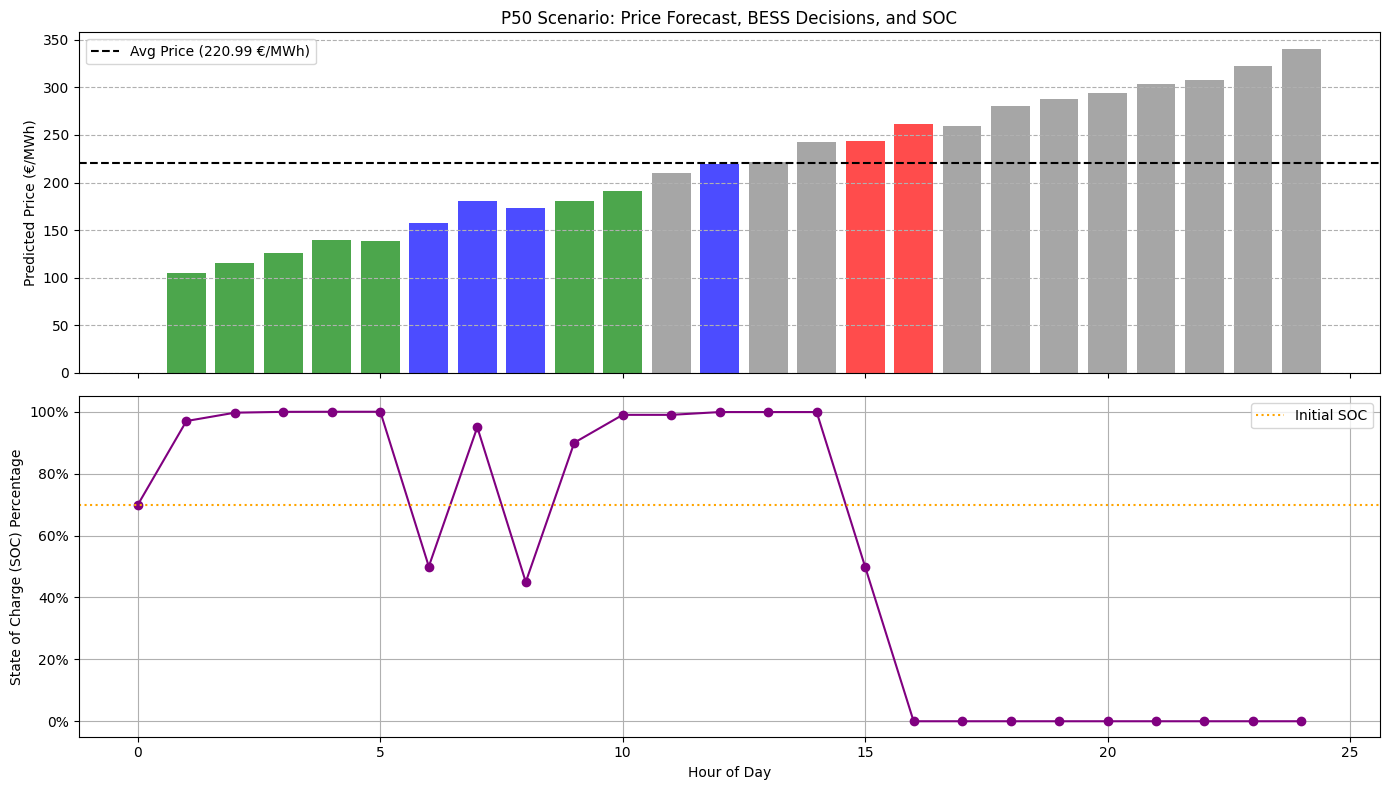

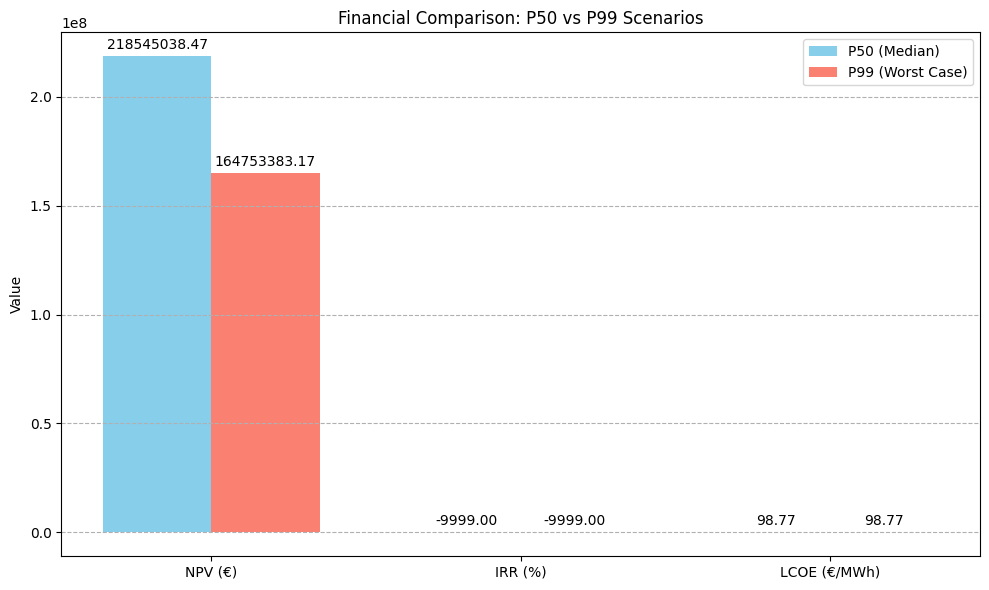

In [22]:
# --- 5. Reporting and Graph Generation ---

print("--- 1Komma5 HEARTBEAT AI - Simplified BESS Analysis ---")
print(f"BESS Capacity: {BESS_CAPACITY_MWH} MWh | Initial SOC: {INITIAL_SOC*100}%")
print(f"Round Trip Efficiency: {ROUND_TRIP_EFFICIENCY*100}% | Discount Rate: {DISCOUNT_RATE*100}%")

print("\n--- Scenario Analysis Results ---")
print(f"{'Metric':<15}{'P50 (Median)':<18}{'P99 (Worst Case)':<18}")
print("-" * 51)
print(f"{'Daily Profit':<15}{P50_PROFIT: <18.2f}{P99_PROFIT: <18.2f} €")
print(f"{'NPV':<15}{P50_NPV: <18.2f}{P99_NPV: <18.2f} €")
print(f"{'IRR':<15}{P50_IRR*100: <18.2f}{P99_IRR*100: <18.2f} %")
print(f"{'LCOE':<15}{P50_LCOE: <18.2f}{P99_LCOE: <18.2f} €/MWh")
print("\n*Note: IRR is the Internal Rate of Return (the discount rate at which NPV=0).")
print("*Note: LCOE is Levelized Cost of Energy (cost per MWh delivered over system life).")

# --- Plot 1: Price Forecast, SOC, and Decision (P50) ---

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)
hours = np.arange(1, 25)
decision_colors = {'Charge (Arb)': 'green', 'Discharge (Arb)': 'red', 'FCR/aFRR': 'blue', 'Hold': 'gray'}
colors = [decision_colors.get(d, 'gray') for d in P50_DECISIONS]

# Plot 1: Price and Decisions
ax1.bar(hours, P50_PRICES, color=colors, alpha=0.7)
ax1.axhline(P50_AVG_PRICE, color='black', linestyle='--', label=f'Avg Price ({P50_AVG_PRICE:.2f} €/MWh)')
ax1.set_ylabel('Predicted Price (€/MWh)')
ax1.set_title('P50 Scenario: Price Forecast, BESS Decisions, and SOC')
ax1.legend(loc='upper left')
ax1.grid(axis='y', linestyle='--')

# Plot 2: State of Charge (SOC)
hours_soc = np.arange(0, 25)
soc_levels_percent = np.array(P50_SOC) / BESS_CAPACITY_MWH
ax2.plot(hours_soc, soc_levels_percent, marker='o', linestyle='-', color='purple')
ax2.set_xlabel('Hour of Day')
ax2.set_ylabel('State of Charge (SOC) Percentage')
ax2.set_yticks(np.arange(0, 1.1, 0.2))
ax2.set_yticklabels([f'{int(s*100)}%' for s in np.arange(0, 1.1, 0.2)])
ax2.axhline(INITIAL_SOC, color='orange', linestyle=':', label='Initial SOC')
ax2.legend()
ax2.grid(True)
plt.tight_layout()
plt.savefig('p50_operational_results.png')

# --- Plot 2: Financial Comparison (P50 vs P99) ---

labels = ['NPV (€)', 'IRR (%)', 'LCOE (€/MWh)']
p50_values = [P50_NPV, P50_IRR * 100, P50_LCOE]
p99_values = [P99_NPV, P99_IRR * 100, P99_LCOE]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, p50_values, width, label='P50 (Median)', color='skyblue')
rects2 = ax.bar(x + width/2, p99_values, width, label='P99 (Worst Case)', color='salmon')

ax.set_ylabel('Value')
ax.set_title('Financial Comparison: P50 vs P99 Scenarios')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--')

# Adding the value labels
def autolabel(rects, is_percent=False):
    for rect in rects:
        height = rect.get_height()
        # Only label if the value is meaningful (e.g., > -100,000 to avoid cluttering failed IRR)
        if height > -100000:
            ax.annotate(f'{height:.2f}{"%" if is_percent else ""}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3), 
                        textcoords="offset points",
                        ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.savefig('financial_comparison.png')

print("\nGenerated plots: p50_operational_results.png (Price/SOC) and financial_comparison.png (NPV/IRR/LCOE)")